In [1]:
!pip install transformers
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from dataclasses import field, dataclass
from typing import Optional
import pandas as pd
import seaborn
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel, AutoConfig
from sklearn.model_selection import train_test_split
import random
import numpy as np
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn.functional as F

Definiamo un dataset per il contrastive learning con text e positive pair

In [3]:
class CLDataset(Dataset):
    def __init__(self, data):
        self.pairs = data
        
    def __len__(self):
        return self.pairs.shape[0]

    def __getitem__(self, idx):
        text = self.pairs['text'].iloc[idx]
        positive = self.pairs['positive'].iloc[idx]
        negative = self.pairs['negative'].iloc[idx]
        ade = self.pairs['ade'].iloc[idx]
        meddra = self.pairs['meddra'].iloc[idx]
        negative_ade = self.pairs['negative_ade'].iloc[idx]
        negative_meddra = self.pairs['negative_meddra'].iloc[idx]
        positive_ade = self.pairs['positive_ade'].iloc[idx]
        positive_meddra = self.pairs['positive_meddra'].iloc[idx]                
        return text, positive, negative, ade, meddra, positive_ade, positive_meddra, negative_ade, negative_meddra


Creiamo il modello usando BERT per il calcolo degli embedding e un layer lineare che allontanerà e avvicinerà gli embedding

In [7]:
class BertCL(nn.Module):
    def __init__(self):
        super(BertCL, self).__init__()

        self.checkpoint = 'dmis-lab/biobert-v1.1'

        # Bert per andare da token a embedding
        self.bert_config = AutoConfig.from_pretrained(self.checkpoint)
        self.bert = AutoModel.from_pretrained(self.checkpoint)

        for param in self.bert.parameters():
            param.requires_grad = False

        # NN per effettuare il contrastive learning
        self.l1 = nn.Linear(self.bert_config.hidden_size, self.bert_config.hidden_size)

        self.drop = nn.Dropout(p=0.4)
        self.activation = nn.Tanh()

    def forward(self, tokenized_sentences):
        sentence_embeddings = self.bert(**tokenized_sentences)
        result = sentence_embeddings.last_hidden_state[:, 0, :]
        result = self.l1(result)
        return self.activation(result)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train = pd.read_csv('/content/positive_negative_pairs_train.csv')

BATCH_SIZE = 256
TRAINING_EPOCHS = 4

checkpoint = 'dmis-lab/biobert-v1.1'
bert_tokenizer = AutoTokenizer.from_pretrained(checkpoint)
bert_config = AutoConfig.from_pretrained(checkpoint)

model = BertCL()
model.to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

train_dataset = CLDataset(train)
train_dataloader = DataLoader(train_dataset,
                              num_workers=2,
                              pin_memory=True, 
                              batch_size=BATCH_SIZE, 
                              shuffle=True)

In [8]:
class ContrastiveTrainingLoss(torch.nn.Module):

    def __init__(self):
        super(ContrastiveTrainingLoss, self).__init__()
        self.cos_sim = torch.nn.CosineSimilarity() 

    def forward(self, inputs, positives, negatives):
        batch_size = inputs.shape[0]
        min_same_pair = self.cos_sim(inputs, positives).abs().mean()
        max_diff_pair = self.cos_sim(inputs, negatives).abs().mean()
        
        return F.relu(min_same_pair + max_diff_pair)

# training e testing

100%|██████████| 4/4 [22:27<00:00, 336.86s/it]


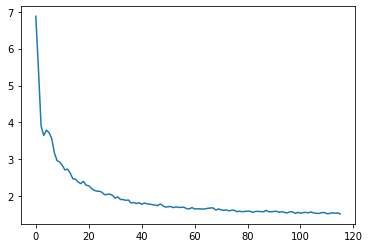

In [9]:
loss = ContrastiveTrainingLoss()
running_loss = []

model.train()
for epoch in tqdm(range(TRAINING_EPOCHS), disable=False):
    for batch_idx, batch in enumerate(train_dataloader):
        sentences, positives, negatives, ades, meddras, positive_ades, positive_meddras, negative_ades, negative_meddras = batch

        optimizer.zero_grad(set_to_none=True)

        tokenization_sentences = bert_tokenizer(list(sentences), padding=True, truncation=True, max_length=bert_config.max_position_embeddings, return_tensors="pt")
        tokenization_positives = bert_tokenizer(list(positives), padding=True, truncation=True, max_length=bert_config.max_position_embeddings, return_tensors="pt") 
        tokenization_negatives = bert_tokenizer(list(negatives), padding=True, truncation=True, max_length=bert_config.max_position_embeddings, return_tensors="pt") 
        tokenization_ades = bert_tokenizer(list(ades), padding=True, truncation=True, max_length=bert_config.max_position_embeddings, return_tensors="pt")
        tokenization_meddras = bert_tokenizer(list(meddras), padding=True, truncation=True, max_length=bert_config.max_position_embeddings, return_tensors="pt")
        tokenization_positive_ades = bert_tokenizer(list(positive_ades), padding=True, truncation=True, max_length=bert_config.max_position_embeddings, return_tensors="pt")
        tokenization_negative_ades = bert_tokenizer(list(negative_ades), padding=True, truncation=True, max_length=bert_config.max_position_embeddings, return_tensors="pt")
        tokenization_negative_meddras = bert_tokenizer(list(negative_meddras), padding=True, truncation=True, max_length=bert_config.max_position_embeddings, return_tensors="pt")

        tokenization_sentences.to(device)
        tokenization_positives.to(device)
        tokenization_negatives.to(device)
        tokenization_ades.to(device)
        tokenization_meddras.to(device)
        tokenization_positive_ades.to(device)
        tokenization_negative_ades.to(device)
        tokenization_negative_meddras.to(device)

        sentence_output = model(tokenization_sentences)
        positive_output = model(tokenization_positives)
        negative_output = model(tokenization_negatives)
        ades_output = model(tokenization_ades)
        meddra_output = model(tokenization_meddras)
        positive_ade_output = model(tokenization_positive_ades)
        negative_meddra_output = model(tokenization_negative_meddras)
        negative_ade_output = model(tokenization_negative_ades)

        # Avviciniamo i positive pairs e i negative pairs sia nel caso delle frasi 
        # sia nel caso degli ade
        sentences_loss = loss(sentence_output, positive_output, negative_output)
        output1 = loss(ades_output, positive_ade_output, negative_ade_output)
        # Avviciniamo gli ade ai corrispondenti meddra allontanando gli altri ade
        output2 = loss(ades_output, meddra_output, negative_meddra_output)
        output3 = loss(meddra_output, meddra_output, negative_meddra_output)
        
        output = sentences_loss + output1 + output2 + output3

        output.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        running_loss.append(output.item())

seaborn.lineplot(x=range(len(running_loss)), y=running_loss)

In [10]:
class CLTestDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        text = self.data['text'].iloc[idx]
        ade = self.data['ade'].iloc[idx]
        meddra = self.data['meddra'].iloc[idx]
            
        return text, ade, meddra

test = pd.read_csv('/content/positive_negative_pairs_test.csv')
test_dataset = CLTestDataset(test)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

model.eval()
test_loss = 0.0
to_classify = test.shape[0]
correctly_classified = 0
correct_meddra_in_top_5 = 0
wrongly_classified = 0

# codifichiamo i meddra 
unique_meddras = test['meddra'].unique()
tokenization_meddra = bert_tokenizer(list(unique_meddras), padding=True, truncation=True,
                                     max_length=bert_config.max_position_embeddings,
                                     return_tensors="pt")
tokenization_meddra.to(device)
encoded_meddras = model(tokenization_meddra)
encoded_meddras.to(device)

for batch_idx, batch in enumerate(tqdm(test_dataloader)):
    sentences, ades, meddras = batch
    
    tokenization_ades = bert_tokenizer(list(ades), padding=True, truncation=True,
                                                max_length=bert_config.max_position_embeddings,
                                                return_tensors="pt")
    tokenization_ades.to(device)

    output = model(tokenization_ades)

    # Controlliamo quale dei meddra ha l'embedding più vicino al ade
    # Ogni riga è la distanza dall'ade in riga i al meddra in colonna j
    distance_encoding_to_meddra = torch.cdist(output, encoded_meddras, p=2)

    # Per ogni riga prendiamo l'indice dei 5 meddra più vicini all'ade
    _, closest_meddra_to_ade_indices = torch.topk(distance_encoding_to_meddra, k=5, dim=1, largest=False)

    for (meddra, closest_meddras_to_ade) in zip(list(meddras), closest_meddra_to_ade_indices):
      closest_meddras = [ unique_meddras[index] for index in closest_meddras_to_ade]

      if closest_meddras[0] == meddra:
        correctly_classified += 1
      elif meddra in closest_meddras:
        correct_meddra_in_top_5 += 1
      else:
        wrongly_classified += 1

print()
print(f"Examples: {to_classify}")
print(f"Correctly classified: {correctly_classified}")
print(f"Correct meddra is in the top 5: {correct_meddra_in_top_5}")


100%|██████████| 23/23 [00:08<00:00,  2.78it/s]


Examples: 5864
Correctly classified: 1598
Correct meddra is in the top 5: 439


In [ ]:
print(len(test[test['ade'] == test['meddra']]))

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline
%pylab inline

vis = test.sample(n=1000, random_state=7)

ade_tok =  bert_tokenizer(vis['ade'].tolist(), padding=True, truncation=True, max_length=bert_config.max_position_embeddings, return_tensors="pt")
meddra_tok = bert_tokenizer(vis['meddra'].unique().tolist(), padding=True, truncation=True, max_length=bert_config.max_position_embeddings, return_tensors="pt")
ade_tok.to(device)
meddra_tok.to(device)

model.eval()
ade_emb = model(ade_tok).tolist()
meddra_emb = model(meddra_tok).tolist()

del ade_tok
del meddra_tok

ade_coords = TSNE(n_components=2, random_state=7).fit_transform(ade_emb)
meddra_coords = TSNE(n_components=2, random_state=7).fit_transform(meddra_emb)

x = [el[0] for el in ade_coords]
y = [el[1] for el in ade_coords]

md_x = [el[0] for el in meddra_coords]
md_y = [el[1] for el in meddra_coords]

vis_ade = pd.DataFrame({
    'type': 'ade',
    'meddra': vis['meddra'],
    'x' : x,
    'y' : y,
})

vis_meddra = pd.DataFrame({
    'type': 'meddra',
    'meddra': vis['meddra'].unique(),
    'x' : md_x,
    'y' : md_y
})

vis_df = pd.concat([vis_ade, vis_meddra])

sns.scatterplot(data=vis_df, 
                x='x', y='y', 
                hue='meddra', 
                style='type').legend([],[], frameon=False)
plt.show()
